In [1]:
%matplotlib notebook

In [2]:
import datajoint as dj
from pipeline import lab, experiment, imaging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Connecting shan@host.docker.internal:3306


## Figure 4e

In [3]:
# helper functions
def compute_mean_sem(traces):
    return np.mean(traces, axis=0), np.std(traces, axis=0)/np.sqrt(len(traces))

def get_event_time(cell):
    events = experiment.TrialEvent & (imaging.TrialTrace & cell)
    sample = np.mean((events & 'trial_event_type = "sample"').fetch('trial_event_time'))
    delay = np.mean((events & 'trial_event_type = "delay"').fetch('trial_event_time'))
    go = np.mean((events & 'trial_event_type = "go"').fetch('trial_event_time'))
    # aligned time markers
    sample = float(sample - go)
    delay = float(delay - go)
    return [sample, delay, 0]

def get_event_idx(event_times, time):
    if len(event_times) == 1:
        return np.abs(time - event_times).argmin()
    else:
        return [np.abs(time - e).argmin() for e in event_times]

In [4]:
# primary keys for example cells
example_cells = [
    {'subject_id': 216219, 'session': 5, 'roi_idx': 22},
    {'subject_id': 216219, 'session': 5, 'roi_idx': 49},
    {'subject_id': 221541, 'session': 13, 'roi_idx': 44},
    {'subject_id': 216219, 'session': 14, 'roi_idx': 9},
    {'subject_id': 216219, 'session': 5, 'roi_idx': 35},
    {'subject_id': 216219, 'session': 6, 'roi_idx': 47},
]

<IPython.core.display.Javascript object>


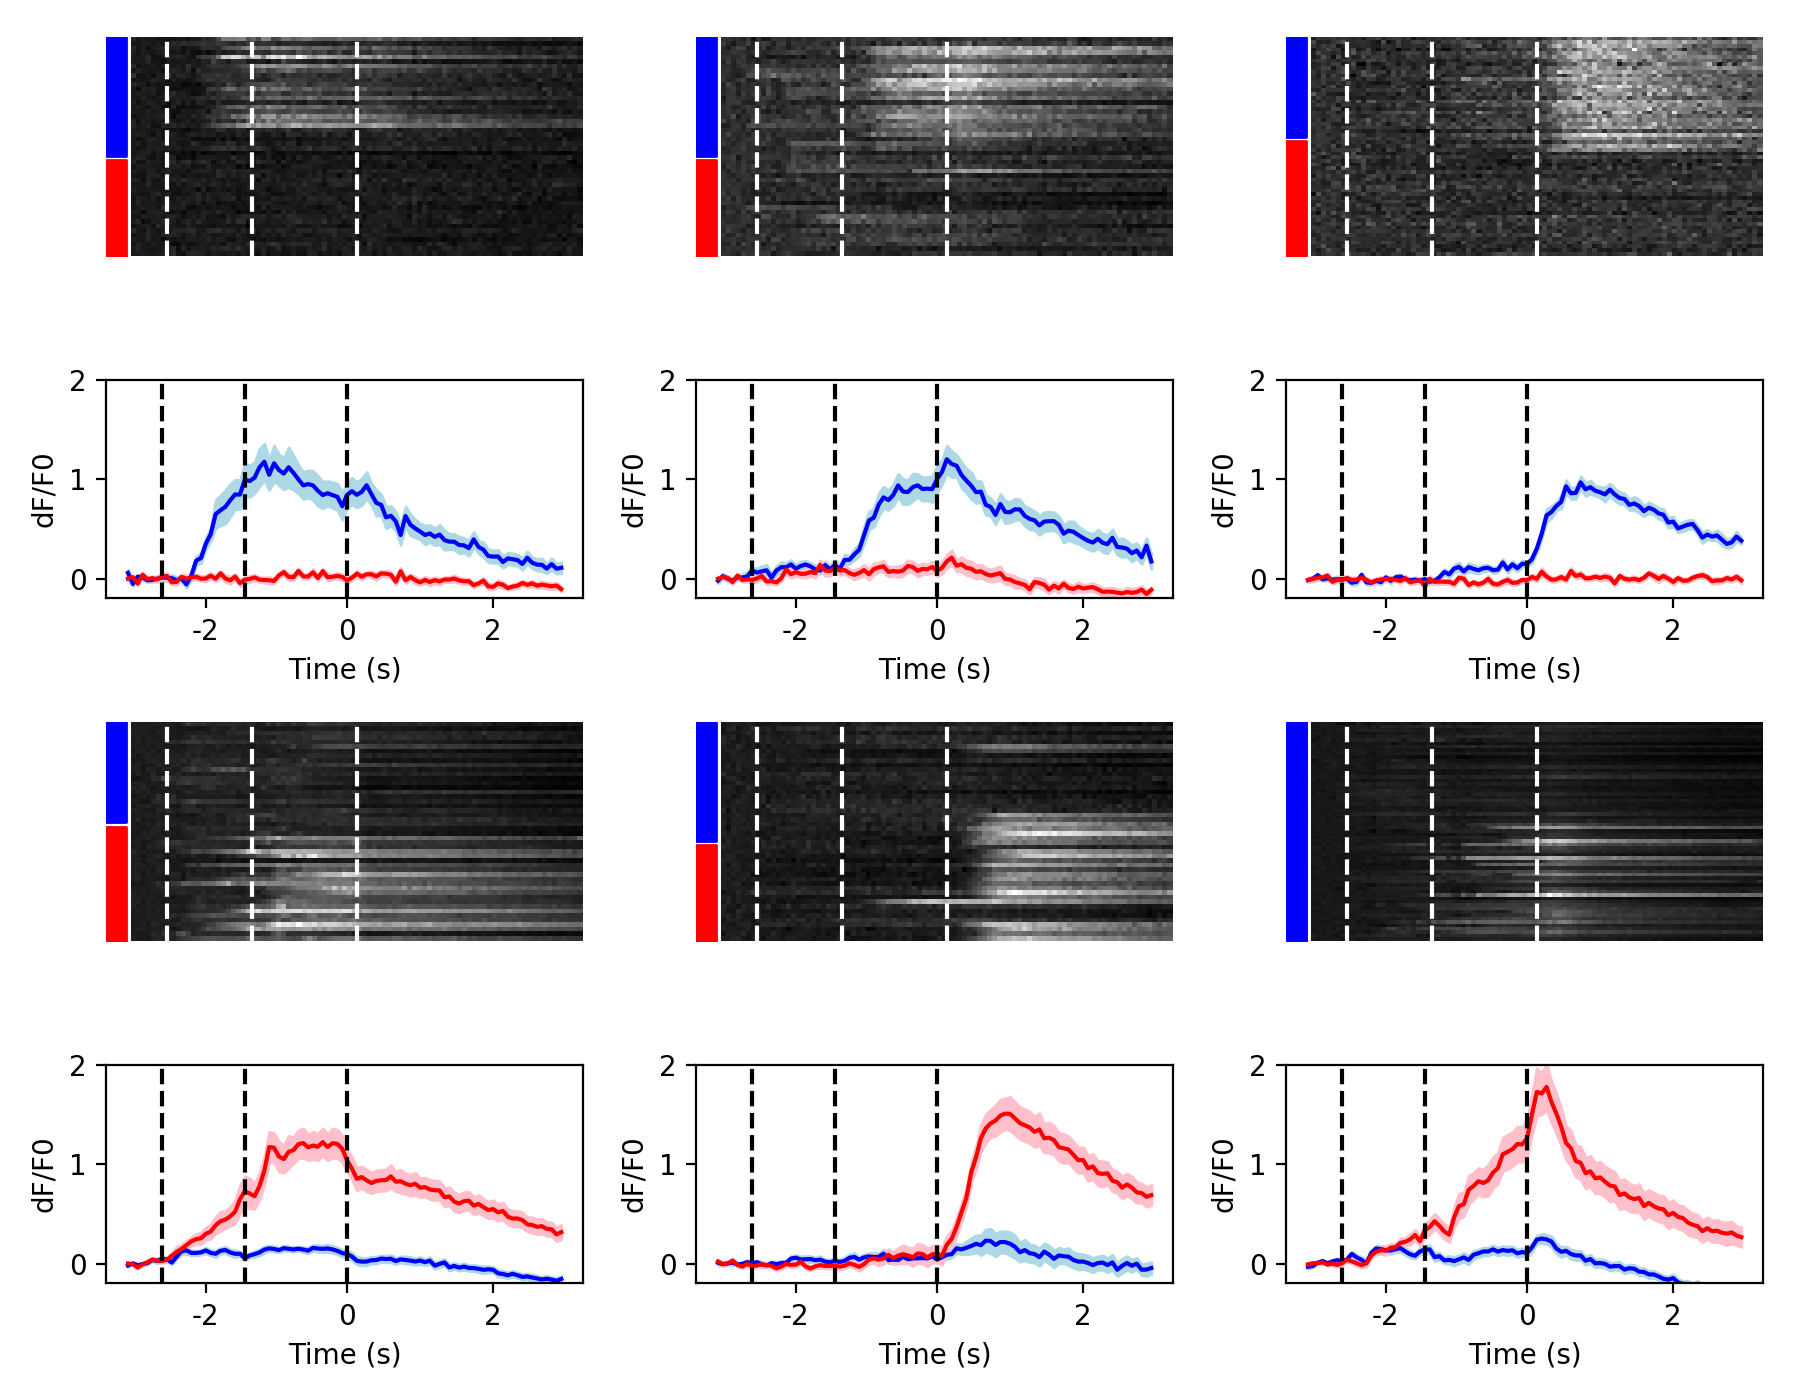

In [5]:
f, axes = plt.subplots(4, 3, figsize=(9, 7))
x2 = -5

axes = axes.flatten()
idx = [[0, 3],
       [1, 4],
       [2, 5],
       [6, 9],
       [7, 10],
       [8, 11]]
axes = [axes[i] for i in idx]

for cell, axs in zip(example_cells, axes):

    # get trace of left trials
    time_left, traces_left = ((imaging.TrialTrace & cell) &
                   (experiment.BehaviorTrial & 'trial_instruction="left"' & 'outcome="hit"')).fetch(
        'aligned_time', 'dff')
    traces_right = ((imaging.TrialTrace & cell) &
                   (experiment.BehaviorTrial & 'trial_instruction="right"' & 'outcome="hit"')).fetch(
        'dff')
    traces_left = [trace for trace in traces_left]
    traces_right = [trace for trace in traces_right]
    time = time_left[0]
    
    # plot heat map
    sns.heatmap(traces_right+traces_left, cmap='gray', cbar=None, ax=axs[0])
    axs[0].fill_betweenx([0, len(traces_left)-1], -1, x2, color='blue')
    axs[0].fill_betweenx([len(traces_left), len(traces_left) + len(traces_right)], -1, x2, color='red')

    # mark event time points
    event_times = get_event_time(cell)
    for idx in get_event_idx(event_times, time):
        axs[0].axvline(x=idx, linestyle='--', color='white')
        
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_xlim((x2, axs[0].get_xlim()[1]))
    
    # mean df/f
    mean_left, sem_left = compute_mean_sem(traces_left)
    mean_right, sem_right = compute_mean_sem(traces_right)
    x = range(0, len(mean_right))
    axs[1].fill_between(x, mean_right-sem_right, mean_right+sem_right, color='lightblue')
    axs[1].plot(x, mean_right, color='blue')
    axs[1].fill_between(x, mean_left-sem_left, mean_left+sem_left, color='pink')
    axs[1].plot(x, mean_left, color='red')
    axs[1].set_ylabel('dF/F0')
    axs[1].set_xlabel('Time (s)')
    xticks = get_event_idx([-2, 0, 2], time)
    axs[1].set_xticks(ticks=xticks)
    labels=['-2', '0', '2']
    axs[1].set_xticklabels(labels)
    
    # mark event time points
    for idx in get_event_idx(event_times, time):
        axs[1].axvline(x=idx, linestyle='--', color='black')
       
    axs[1].set_ylim([-0.2, 2])

f.tight_layout()

## Figure 4f

In [9]:
# get pt cells in L5
L5_key = (experiment.Session.ImagingDepth & 'imaging_depth>450')
pt_contra_cells = (imaging.RoiAnalyses & 'is_reponsive=1' & 'selectivity="Contra"') & \
                  (imaging.Scan.Roi & 'cell_type="PT"' & 'inc=1') & L5_key
                  
pt_ipsi_cells = (imaging.RoiAnalyses & 'is_reponsive=1' & 'selectivity="Ipsi"') & \
                (imaging.Scan.Roi & 'cell_type="PT"' & 'inc=1') & L5_key

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:169: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


In [10]:
pt_contra_avg_l, pt_contra_avg_r = pt_contra_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
pt_ipsi_avg_l, pt_ipsi_avg_r = pt_ipsi_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
pt_contra_avg_l = [f for f in pt_contra_avg_l]
pt_contra_avg_r = [f for f in pt_contra_avg_r]
pt_ipsi_avg_l = [f for f in pt_ipsi_avg_l]
pt_ipsi_avg_r = [f for f in pt_ipsi_avg_r]

<IPython.core.display.Javascript object>


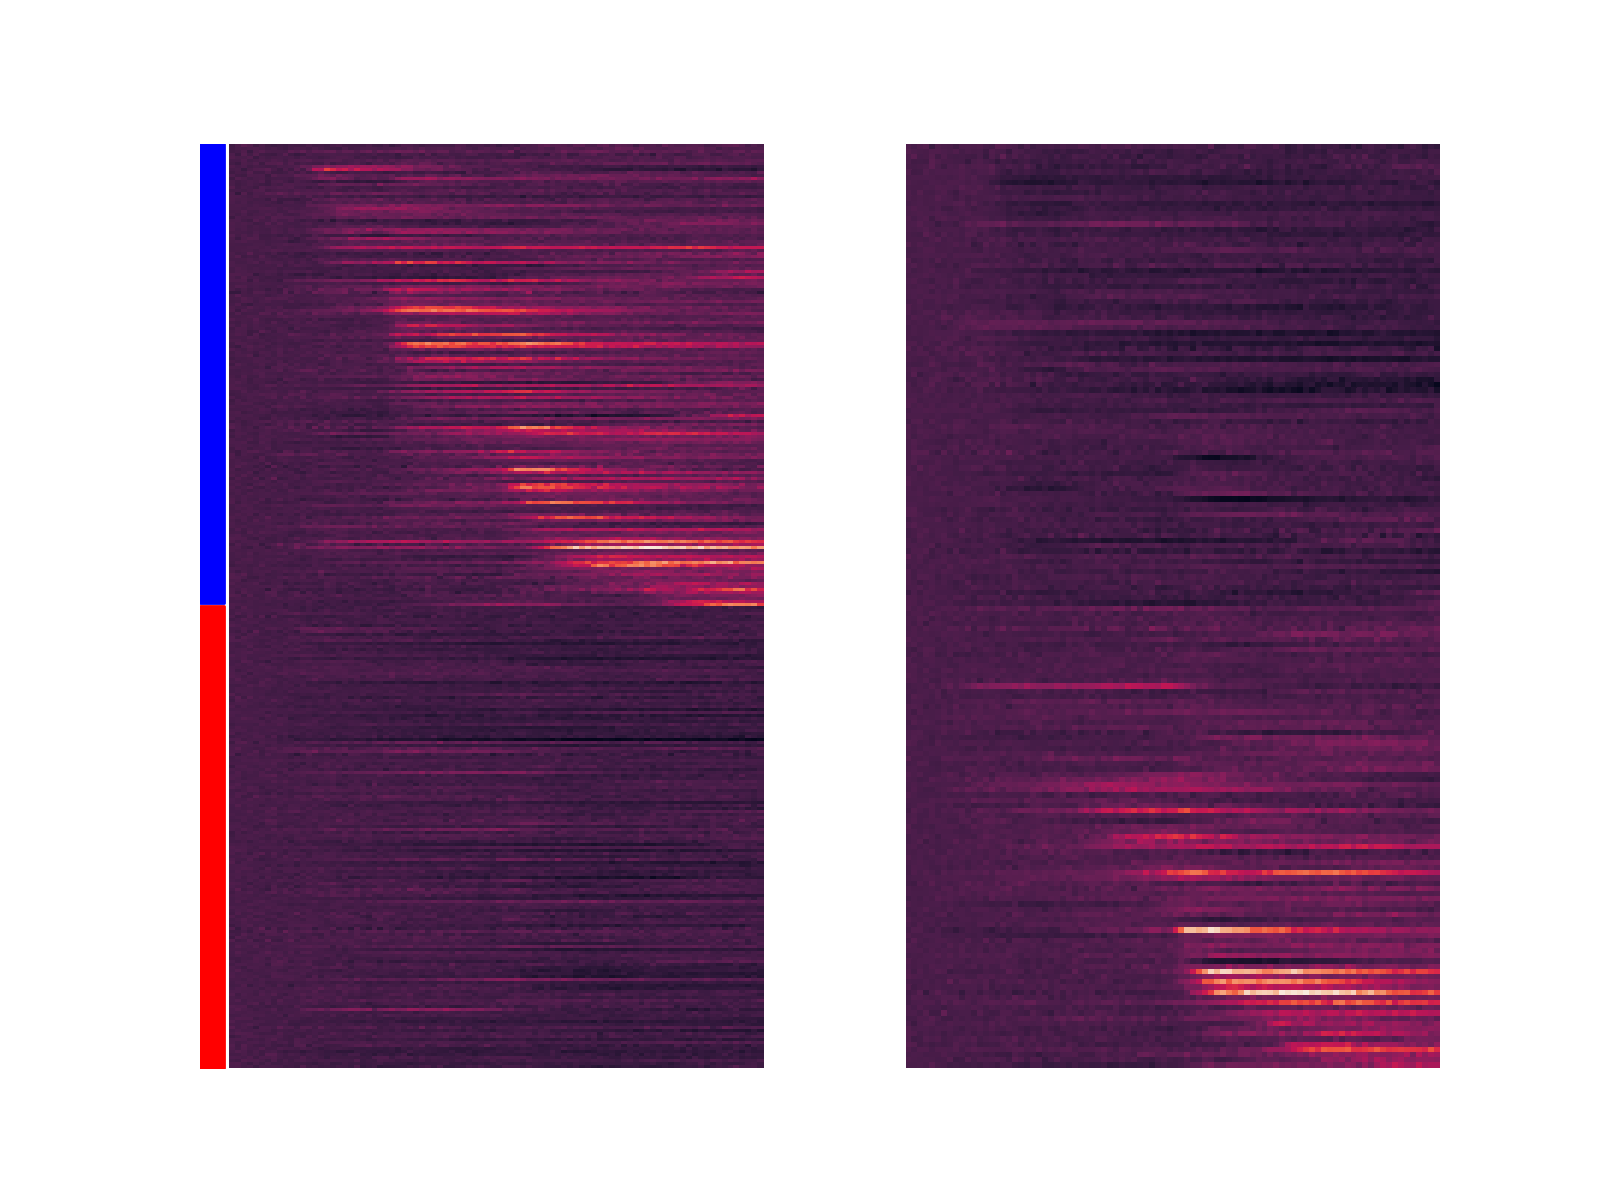

In [48]:
f2, axes = plt.subplots(1, 2, figsize=[8, 6])

sns.heatmap(pt_contra_avg_r+pt_contra_avg_l, cbar=None, ax=axes[0])
sns.heatmap(pt_ipsi_avg_r+pt_ipsi_avg_l, cbar=None, ax=axes[1])
axes[0].fill_betweenx([0, len(pt_contra_avg_r)-1], -1, x2, color='blue')
axes[0].fill_betweenx([len(pt_contra_avg_r), len(pt_contra_avg_r) + len(pt_contra_avg_l)], -1, x2, color='red')
axes[0].set_xlim((x2, axes[0].get_xlim()[1]))
axes[1].set_xlim((x2, axes[0].get_xlim()[1]))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [30]:
it_contra_cells = (imaging.RoiAnalyses & 'is_reponsive=1' & 'selectivity="Contra"') & \
                  (imaging.Scan.Roi & 'cell_type="IT"' & 'inc=1') & L5_key
                  
it_ipsi_cells = (imaging.RoiAnalyses & 'is_reponsive=1' & 'selectivity="Ipsi"') & \
                (imaging.Scan.Roi & 'cell_type="IT"' & 'inc=1') & L5_key

In [31]:
it_contra_avg_l, it_contra_avg_r = it_contra_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
it_ipsi_avg_l, it_ipsi_avg_r = it_ipsi_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
it_contra_avg_l = [f for f in it_contra_avg_l]
it_contra_avg_r = [f for f in it_contra_avg_r]
it_ipsi_avg_l = [f for f in it_ipsi_avg_l]
it_ipsi_avg_r = [f for f in it_ipsi_avg_r]

<IPython.core.display.Javascript object>


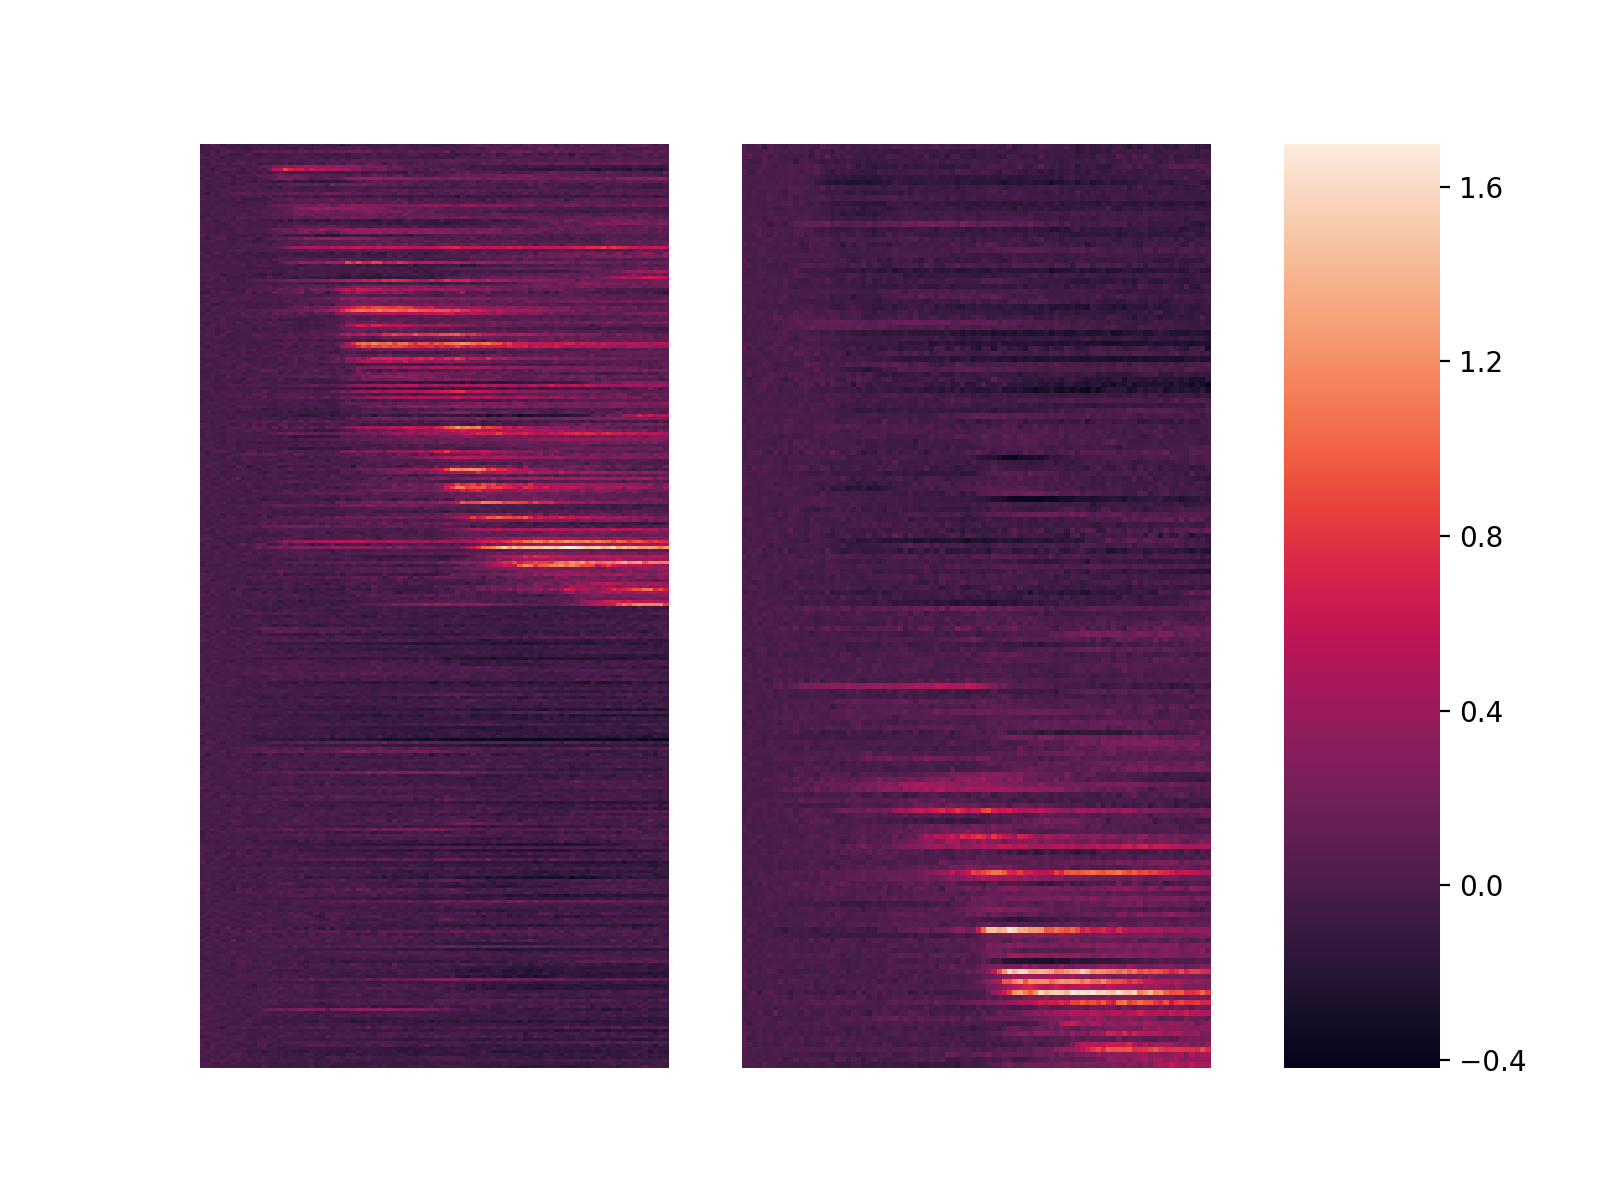

/usr/local/lib/python3.6/dist-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


In [32]:
f3, axes = plt.subplots(1, 2, figsize=[8,6])
sns.heatmap(pt_contra_avg_r+pt_contra_avg_l, cbar=None, ax=axes[0])
ax
sns.heatmap(pt_ipsi_avg_r+pt_ipsi_avg_l, ax=axes[1], cbar=True, cbar_ax=axes[2])
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])